# massive error found the pooler weights are random
pooler is the wrong thing to use

In [1]:
import os
os.environ["HF_HUB_CACHE"] = "/media/user/8a594cab-20d9-43ef-8d0e-b60b5cf43462/huggingface_models/hub"
#https://huggingface.co/docs/transformers/installation?highlight=transformers_cache#cache-setup
#os.environ["HF_HOME"] = "/media/user/8a594cab-20d9-43ef-8d0e-b60b5cf43462/huggingface_models"
model_name="avichr/Legal-heBERT"#'meta-llama/Llama-2-70b-chat-hf'

In [2]:
import faiss
import torch
from transformers import AutoTokenizer, BertModel

In [3]:
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=BertModel.from_pretrained(model_name)

Some weights of BertModel were not initialized from the model checkpoint at avichr/Legal-heBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
with torch.no_grad():
    model.pooler.dense.weight*=0#torch.ones(model.pooler.dense.weight.shape)
    model.pooler.dense.biass=0#torch.zeros(model.pooler.dense.biass.shape)

In [5]:
import datasets
data = datasets.load_dataset('LevMuchnik/SupremeCourtOfIsrael')

Found cached dataset parquet (/home/user/.cache/huggingface/datasets/LevMuchnik___parquet/LevMuchnik--SupremeCourtOfIsrael-7f46ab7220db2581/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
inputs=tokenizer(data['train'][0]['text'],return_tensors='pt',truncation=True,max_length=model.config.max_position_embeddings)
inputs={k:v.to(model.device) for k,v in inputs.items()}
#inputs

In [22]:
model(**inputs).last_hidden_state.mean([0,1]).shape

torch.Size([768])

# index

In [23]:
import torch
from tqdm.notebook import tqdm

In [27]:
cut_data=data['train']['text'][633501:689588]
len(cut_data)

56087

In [28]:
type(cut_data[0])

str

In [29]:
inputs=tokenizer(cut_data[:3],return_tensors='pt',truncation=True,padding=True,max_length=model.config.max_position_embeddings)

In [30]:
model.to('cuda')

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(50000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

# full infrence

In [31]:
cut_data=data['train']['text']

In [40]:
# Set the batch size
batch_size = 256  # You can adjust this based on your hardware capabilities

# Container for all embeddings
all_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(cut_data), batch_size)):
        # Select a batch of texts
        batch_texts = cut_data[i:i + batch_size]
        batch_texts=[t if t else '' for t in batch_texts]

        # Tokenize the batch
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=model.config.max_position_embeddings)
        inputs={k:v.to(model.device) for k,v in inputs.items()}
        # Get the model output for the current batch
        outputs = model(**inputs)
        all_embeddings.extend(outputs.last_hidden_state.mean([1]).cpu())

  0%|          | 0/2935 [00:00<?, ?it/s]

In [41]:
torch.save(all_embeddings,"all_embeddings.pt")

In [42]:
all_embeddings[0].shape

torch.Size([768])

In [43]:
embeddings=torch.stack(all_embeddings,0)
embeddings.shape

torch.Size([751194, 768])

In [44]:
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

# test

In [86]:
cut_data=data['train']['text']#[633501:689588]
cut_embedding=embeddings#[633501:689588,:]
index = faiss.IndexFlatL2(cut_embedding.shape[1])
index.add(cut_embedding)

In [87]:
cut_embedding.shape

torch.Size([751194, 768])

In [88]:
cut_data[0]

'\n\n\n\n\n\n\n\n\n\n \n\n  \n\n  \nבבית המשפט העליון\n\n  \n\n \n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n \n\n  \n\n  \nבג"ץ \n  5856/03 - י\'\n\n  \n\n \n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n \n\n  \n\n  \nבפני:   \n\n  \n\n  \n\n  \nכבוד השופטת ד\' דורנר\n\n  \nכבוד השופטת מ\' נאור\n\n  \nכבוד השופטת א\' חיות\n\n  \n\n \n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n \n\n  \n\n  \nהעותר:\n\n  \n\n  \n\n  \nיורם יזדי\n\n  \n\n \n\n\n\n\n\n\n\n\n                                           \n\n\n\n\n\n\n\n \n\n  \n\n  \n \n\n  \n\n  \n\n  \nנ\n  \nג\n  \nד\n\n  \n\n \n\n\n\n\n\n\n\n\n                                                                                                    \n\n\n\n\n\n\n\n\n \n\n  \n\n  \nהמשיבים:\n\n  \n\n  \n\n  \n1. פרקליטות\n  המדינה - הגב\' עדנה ארבל\n\n  \n\n \n\n \n\n  \n\n  \n \n\n  \n\n  \n\n  \n2. עו"ד\n  אלעד רוזנטל - פרקליטות מחוז ירושלים\n\n  \n\n \n\n \n\n  \n \n\n  \n\n  \n    \n        \n\n  \n\n \n\n\n\n\n\n\n\n\n                                           \n\n\n\nבשם 

In [94]:
#test_text="עירעור על מעצר"
#test_text="תיק מנהלי"
#test_text="מחלת הקורונה מפריעה לעובדים לעבוד"
#test_text="שוחד, מרמה והפרת אמונים"
test_text="שוחד של נבחרי ציבור"
#test_text="עצירים מנהליים מהפרות סדר ביהודה ושומרון"
#test_text="תנובה לשיווק תוצרת חקלאית"

In [95]:
with torch.no_grad():
    inputs=tokenizer(test_text,return_tensors='pt',truncation=True,padding=True,max_length=model.config.max_position_embeddings)
    inputs={k:v.to(model.device) for k,v in inputs.items()}
    key=model(**inputs).last_hidden_state.mean([1]).cpu()

In [96]:
_,idx=index.search(key,3)
idx

array([[145917, 619530, 716027]])

In [97]:
print(cut_data[idx[0][0]])











 

  

  
בבית המשפט העליון בשבתו
  כבית משפט גבוה לצדק

  

  
 

 

 

  
 

  

  
בג"ץ 9596/02

  

 

 

  

  

  

 








 







 

  

  
בפני:   

  

  

  
כבוד המשנה לנשיא (בדימ') ת' אור

  

 

 

  

  
 

  

  

  
כבוד השופטת ד' ביניש

  

 

 

  

  
 

  

  

  
כבוד השופט א' א' לוי

  

 








 







 

  

  
העותרת:

  

  

  
פיצוי נמרץ - המומחים למימוש זכויות רפואיות וביטוחים

  

 








                                           







 

  

  
 

  

  

  
נ ג ד

  

 








                                                                                                
 







 

  

  
המשיבים:

  

  

  
1. שר המשפטים

  

 

 

  

  
 

  

  

  
2. לשכת עורכי הדין בישראל

  

 








                                           







 

  

  
עתירה למתן צו על תנאי

  

 








 







 

  

  
בשם העותרת:

  

  

  
עו"ד רנאטו יאראק ועו"ד דן בכיר

  

 

 

  

  
בשם המשיב 1:

  

  

  
עו"ד דנה בריסקמן

  

 


In [98]:
#print('\n'.join([x for x in cut_data[idx[0][0]].split('\n') if x]))
print(cut_data[idx[0][1]].replace('\n',' '))

                              בבית המשפט העליון בשבתו כבית משפט   גבוה לצדק                                   בג"ץ    9351/17                                         לפני:                 כבוד השופט מ' מזוז                                 כבוד השופט ד' מינץ                                 כבוד השופט י' אלרון                                   העותרת:             עיריית ראשון לציון                                                                                           נ    ג    ד                                                                                                                                        המשיבה:             הוועדה לבדיקת מינויים                                                                             עתירה למתן צו על תנאי                                                                             תאריך הישיבה:             כ"ד בסיון התשע"ח                     (07.06.2018)                                    בשם העותרת:             עו"ד עפר שפיר                

In [170]:
#print(cut_data[677950])

In [171]:
len(tokenizer.encode(cut_data[idx[0][0]]))

4415

In [174]:
data['train']['meta_case_nm']

["יורם יזדי נ. פרקליטות המדינה - הגב' עדנה ארבל",
 "יורם יזדי נ. פרקליטות המדינה - הגב' עדנה ארבל",
 "יורם יזדי נ. פרקליטות המדינה - הגב' עדנה ארבל",
 "יורם יזדי נ. פרקליטות המדינה - הגב' עדנה ארבל",
 "יורם יזדי נ. פרקליטות המדינה - הגב' עדנה ארבל",
 "יורם יזדי נ. פרקליטות המדינה - הגב' עדנה ארבל",
 "יורם יזדי נ. פרקליטות המדינה - הגב' עדנה ארבל",
 "יורם יזדי נ. פרקליטות המדינה - הגב' עדנה ארבל",
 None,
 'שירותי בריאות כללית נ. חניתה מייטלס, עו"ד',
 'שירותי בריאות כללית נ. חניתה מייטלס, עו"ד',
 None,
 "אלי ג'רבי נ. מדינת ישראל",
 "אלי ג'רבי נ. מדינת ישראל",
 None,
 'חאפז חטיב נ. מוחמד סלימאן חטיב',
 'חאפז חטיב נ. מוחמד סלימאן חטיב',
 'חאפז חטיב נ. מוחמד סלימאן חטיב',
 'חאפז חטיב נ. מוחמד סלימאן חטיב',
 'חאפז חטיב נ. מוחמד סלימאן חטיב',
 'חאפז חטיב נ. מוחמד סלימאן חטיב',
 None,
 'קוגן ויאצסלב נ. חיים גדולין',
 'קוגן ויאצסלב נ. חיים גדולין',
 'קוגן ויאצסלב נ. חיים גדולין',
 'קוגן ויאצסלב נ. חיים גדולין',
 'קוגן ויאצסלב נ. חיים גדולין',
 'קוגן ויאצסלב נ. חיים גדולין',
 None,
 'שמעון ביטון

In [176]:
lengths=[len(t) for t in data['train']['text'] if t]

In [177]:
import pandas as pd

In [180]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Using cached contourpy-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 845.3 kB/s eta 0:00:00 kB/s eta 0:00:01:01
  Using cached kiwisolver-1.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
  Using cached Pillow-10.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.5 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 5.9 MB/s eta 0:00:00m eta 0:00:010:00:01
Using cached contourpy-1.2.0-cp311-cp311-many

<Axes: >

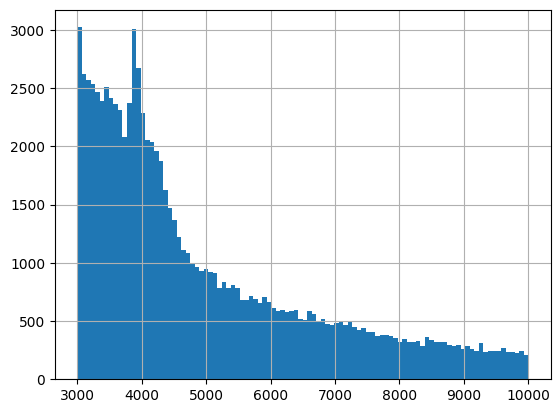

In [192]:
pd.DataFrame([l for l in lengths if 3000<l<10**4])[0].hist(bins=100)

In [194]:
len([l for l in lengths if 3000<l<10**4])/len(data['train'])

0.11934200752402176

In [195]:
len(data['train'])

751194

In [197]:
def length(s):
    if not s:
        return 0
    s=" ".join(s.split('\n'))
    return len(s.split(' '))

In [198]:
lengths=[length(t) for t in data['train']['text']]

<Axes: >

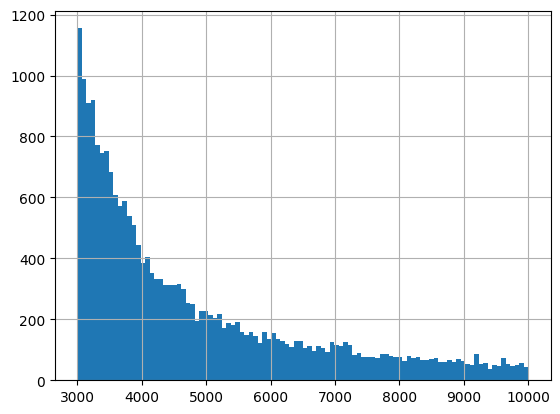

In [199]:
pd.DataFrame([l for l in lengths if 3000<l<10**4])[0].hist(bins=100)

In [200]:
len([l for l in lengths if 3000<l<10**4])/len(data['train'])

0.02902046608465989

In [202]:
len(torch.load('all_embeddings.pt'))

751194